In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:08:53_PST_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0
gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-44)
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
!unzip d_log_out.zip

In [ ]:
# install dependencies: (use cu111 because colab has CUDA 11.1)
# %pip install -U openmim
# !mim install "mmengine>=0.7.0"
# !mim install "mmcv>=2.0.0rc4"

# Install mmdetection
# !rm -rf mmdetection
# !git clone https://github.com/open-mmlab/mmdetection.git
# %cd mmdetection

# %pip install -e .

In [2]:
from mmengine.utils import get_git_hash
from mmengine.utils.dl_utils import collect_env as collect_base_env

import mmdet


def collect_env():
    """Collect the information of the running environments."""
    env_info = collect_base_env()
    env_info['MMDetection'] = f'{mmdet.__version__}+{get_git_hash()[:7]}'
    return env_info


if __name__ == '__main__':
    for name, val in collect_env().items():
        print(f'{name}: {val}')

sys.platform: linux
Python: 3.9.12 (main, Apr  5 2022, 06:56:58) [GCC 7.5.0]
CUDA available: True
MUSA available: False
numpy_random_seed: 2147483648
GPU 0: NVIDIA A100-SXM4-80GB
CUDA_HOME: /shared/centos7/cuda/11.2
NVCC: Cuda compilation tools, release 11.2, V11.2.67
GCC: gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-44)
PyTorch: 2.4.1+cu121
PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2021.4-Product Build 20210904 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.4.2 (Git Hash 1137e04ec0b5251ca2b4400a4fd3c667ce843d67)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode

In [ ]:
# We download the pre-trained checkpoints for inference and finetuning.
# !mkdir ./checkpoints
# !mim download mmdet --config co_dino_5scale_r50_8xb2_1x_coco --dest ./checkpoints

In [3]:
from mmdet.apis import DetInferencer

/home/su.cao/.local/lib/python3.9/site-packages/mmengine/optim/optimizer/zero_optimizer.py:11: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \


In [4]:
print(123)

123


In [3]:
config_forestfire = """
# Inherit and overwrite part of the config based on this config
_base_ = '/home/su.cao/mmdetection/projects/CO-DETR/configs/codino/co_dino_5scale_r50_8xb2_1x_coco.py'

data_root = 'd_log_out/' # dataset root

train_batch_size_per_gpu = 1
train_num_workers = 2

max_epochs = 150
stage2_num_epochs = 1
base_lr = 0.00008


metainfo = {
    'classes': ('trees', 'Alive Tree','Beetle Fire Tree','Dead Tree','Debris',),
    'palette': [
        (220, 20, 60),(128, 255, 0),(102, 102, 255),(255, 255, 0),(255, 128, 0),
    ]
}

train_dataloader = dict(
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        ann_file='train.json',
        pipeline=[
            dict(type='LoadImageFromFile', imdecode_backend='tifffile', to_float32=True),
            dict(type='LoadAnnotations', with_bbox=True),
            dict(type='Resize',scale_factor=1.0, keep_ratio=True),
            dict(
                meta_keys=(
                    'img_id',
                    'img_path',
                    'ori_shape',
                    'img_shape',
                    'scale_factor',
                ),
                type='PackDetInputs'),
        ],
        data_prefix=dict(img='train/')))

val_dataloader = dict(
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        ann_file='val.json',
        pipeline=[
            dict(type='LoadImageFromFile', imdecode_backend='tifffile', to_float32=True),
            dict(type='LoadAnnotations', with_bbox=True),
            dict(type='Resize',scale_factor=1.0, keep_ratio=True),
            dict(
                meta_keys=(
                    'img_id',
                    'img_path',
                    'ori_shape',
                    'img_shape',
                    'scale_factor',
                ),
                type='PackDetInputs'),
        ],
        data_prefix=dict(img='val/')))


test_dataloader = val_dataloader

val_evaluator = dict(
    classwise = True,
    ann_file=data_root + 'val.json'
)

test_evaluator = val_evaluator

model = dict(
    data_preprocessor=dict(
        type='DetDataPreprocessor',
        mean=[0.5070, 0.4865, 0.4409],
        std=[0.2673, 0.2564, 0.2761],
        bgr_to_rgb=False,
        pad_size_divisor=1)
)



# learning rate
# param_scheduler = [
#     dict(
#         type='LinearLR',
#         start_factor=1.0e-5,
#         by_epoch=False,
#         begin=0,
#         end=10),
#     dict(
#         # use cosine lr from 10 to 20 epoch
#         type='CosineAnnealingLR',
#         eta_min=base_lr * 0.05,
#         begin=max_epochs // 2,
#         end=max_epochs,
#         T_max=max_epochs // 2,
#         by_epoch=True,
#         convert_to_iter_based=True),
# ]

# train_pipeline_stage2 = [
#     dict(type='LoadImageFromFile', backend_args=None),
#     dict(type='LoadAnnotations', with_bbox=True),
#     dict(
#         type='RandomResize',
#         scale=(640, 640),
#         ratio_range=(0.1, 2.0),
#         keep_ratio=True),
#     dict(type='RandomCrop', crop_size=(640, 640)),
#     dict(type='YOLOXHSVRandomAug'),
#     dict(type='RandomFlip', prob=0.5),
#     dict(type='Pad', size=(640, 640), pad_val=dict(img=(114, 114, 114))),
#     dict(type='PackDetInputs')
# ]

# optimizer
# optim_wrapper = dict(
#     _delete_=True,
#     type='OptimWrapper',
#     optimizer=dict(type='AdamW', lr=base_lr, weight_decay=0.05),
#     paramwise_cfg=dict(
#         norm_decay_mult=0, bias_decay_mult=0, bypass_duplicate=True))

default_hooks = dict(
    checkpoint=dict(
         interval=5,
         max_keep_ckpts=2,  # only keep latest 2 checkpoints
         save_best='auto'
     ),
     logger=dict(type='LoggerHook', interval=5))

# custom_hooks = [
#     dict(
#         type='PipelineSwitchHook',
#         switch_epoch=max_epochs - stage2_num_epochs,
#         switch_pipeline=train_pipeline_stage2)
# ]

# load COCO pre-trained weight
load_from = 'co_dino_5scale_swin_large_16e_o365tococo-614254c9.pth'
#resume=True

# train_cfg = dict(type='EpochBasedTrainLoop', max_epochs=max_epochs, val_interval=1)
# visualizer = dict(vis_backends=[dict(type='LocalVisBackend'),dict(type='TensorboardVisBackend')])
"""

with open('tmp_configs/d_log_config.py', 'w') as f:
    f.write(config_forestfire)

In [ ]:
!python mmdetection/tools/train.py tmp_configs/d_log_config.py
# !python mmdetection/tools/train.py work_dirs/rtmdet_tiny_ForestFire_COCO_MMD/20241101_141858/vis_data/config.py

/home/su.cao/.local/lib/python3.9/site-packages/mmengine/optim/optimizer/zero_optimizer.py:11: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \
11/20 22:58:44 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.9.12 (main, Apr  5 2022, 06:56:58) [GCC 7.5.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1494460743
    GPU 0: NVIDIA A100-SXM4-80GB
    CUDA_HOME: /shared/centos7/cuda/11.2
    NVCC: Cuda compilation tools, release 11.2, V11.2.67
    GCC: gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-44)
    PyTorch: 2.4.1+cu121
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2021.4-Product Build 20210904 for Intel(R) 64 arc

In [ ]:
from mmdet.apis import DetInferencer
import glob
config = 'mmdetection/configs/rtmdet/rtmdet_tiny_ForestFire_COCO_MMD.py'
checkpoint = glob.glob('work_dirs/rtmdet_tiny_ForestFire_COCO_MMD/best_coco_Alive Tree_precision_epoch_15.pth')[0]
device = 'cuda:0'
# Initialize the DetInferencer
inferencer = DetInferencer(config, checkpoint, device)
img = 'LogRBG/test/DJI_20240806142417_0250_jpg.rf.9b23e94f71f0b9692956d1bb7298b5cb.jpg'
result = inferencer(img, out_dir='./output')

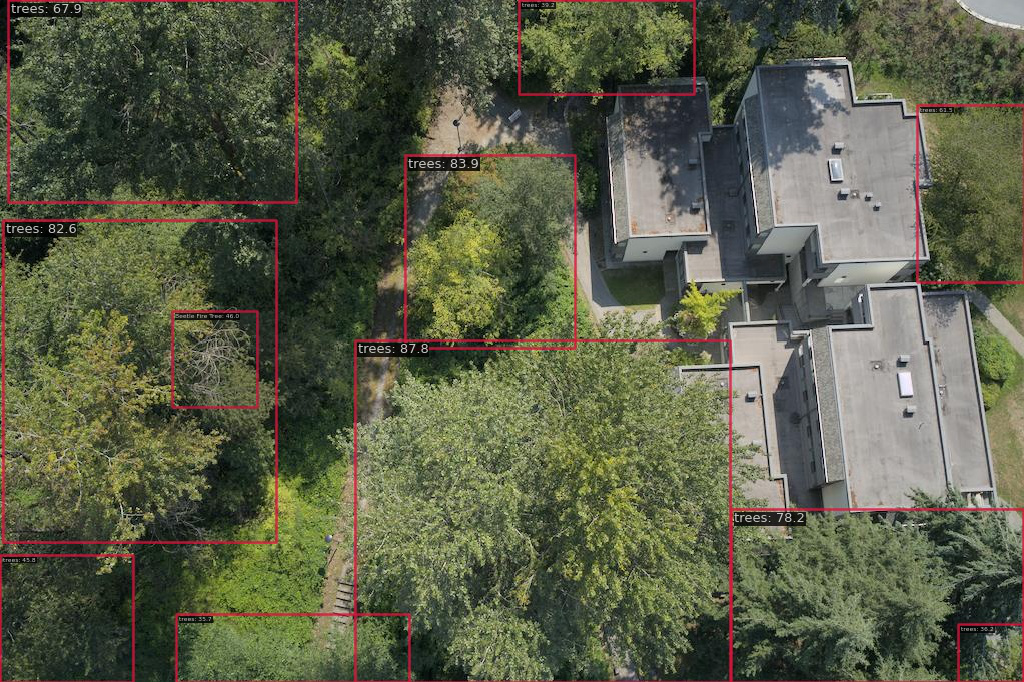

In [9]:
from PIL import Image
Image.open('output/vis/DJI_20240806142417_0250_jpg.rf.9b23e94f71f0b9692956d1bb7298b5cb.jpg')